In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import erfinv
import scipy.optimize as opt
from scipy.stats import chi2 

%matplotlib inline

In [2]:
class Linear:
    # Define a class that creates a linear distribution
    def __init__(self,intercept,slope,lo,hi):
        # Initialise variables of the class
        self.mass = [] # Empty for now but will be filled up with 'nexts' function
        self.intercept = intercept
        self.slope = slope
        self.lolimit = lo
        self.hilimit = hi*2
        self.maxval = hi
        
    # Evaluate method (un-normalised)
    def evaluate(self,t):
        return  self.intercept + self.slope * t

    def nexts(self,length):
        # Fill in the distribution (pdf) with values from the linear distribution
        k=0
        while k<length:
            # start with uniform random number in [lolimit,hilimit)
            x = np.random.uniform(self.lolimit,self.hilimit)
            y1 = self.evaluate(x)
            y2 = np.random.uniform(0,self.maxval)
            if (y2<y1):
                filtered_x = x
                self.mass.append(filtered_x)
                k+=1
        
class Gaussian:
    # Define a class that creates a Gaussian distribution
    def __init__(self,mean,sigma):
        # Initialise variables of the class
        self.mass = []
        self.mean = mean
        self.sigma = sigma
        
    def nexts(self,length):
        # Fill in the distribution (pdf) with values from the normal distribution
        k = 0
        while k<length:
            x = np.random.normal(self.mean,self.sigma)
            k += 1
            self.mass.append(x)
            
    def integral(self,total,length):
        func = lambda x: 1/(self.sigma*np.sqrt(2*np.pi))*np.exp(-np.square(x-self.mean)/(2*np.square(self.sigma)))
        integ1 = integrate.quad(func,total,self.mean+(20*self.sigma)) #use 20 sigma to approximate infinity
        integ2 = integrate.quad(func,self.mean-(20*self.sigma),self.mean+(20*self.sigma)) #same again as np.inf throws
        # up errors
        
        return integ1[0]/integ2[0] #Returns normalised integral

class SignalWithBackground:
    
    def __init__(self,intercept,slope,lo,hi,mean,sigma):
         # Initialise variables of the class
        self.mass_sig = []
        self.mass_bgd = []
        self.background = Linear(intercept,slope,lo,hi)
        self.signal = Gaussian(mean,sigma)
        self.mass = []
        
    def summing(self,lenbgd,lensig):
        #Creating output of combined linear and normal distribution
        self.background.nexts(lenbgd)
        self.signal.nexts(lensig)
        self.mass_bgd = self.background.mass
        self.mass_sig = self.signal.mass
        self.mass = self.mass_bgd+self.mass_sig   

In [3]:
# background parameters
XMIN = 0.
XMAX = 20.
intercept = 20.
slope = -1.
# signal parameters
mean = 10.
sigma = 0.5
# choose number of bins that is appropriate for the size of the statistics sample
NBINS = 100
# Lengths of arrays
lenbgd = 10000
lensig = 300

# Define the pdf
pdf = SignalWithBackground(intercept,slope,XMIN,XMAX,mean,sigma)
#Initialise the mass array
pdf.summing(lenbgd,lensig)

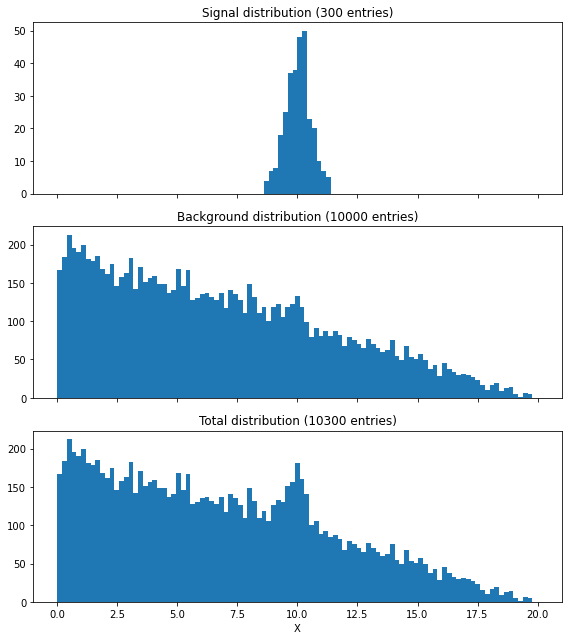

In [4]:
#plotting the distributions
myRange = (XMIN,XMAX)
fig,axs = plt.subplots(3,1,sharex ='col',figsize=(8,9))
axs[0].set_title("Signal distribution (" + str(len(pdf.mass_sig)) + " entries)")
axs[1].set_title("Background distribution (" + str(len(pdf.mass_bgd)) + " entries)")
axs[2].set_title("Total distribution (" + str(len(pdf.mass)) + " entries)")
axs[2].set_xlabel('X')
axs[0].hist(pdf.mass_sig,bins = NBINS,range = myRange)
axs[1].hist(pdf.mass_bgd,bins = NBINS)
axs[2].hist(pdf.mass,bins = NBINS)
fig.tight_layout()
plt.show()

In [5]:
#Task 2
gauss_p = Gaussian(mean = 10000,sigma = 100) #creating gaussian function
pvalue = gauss_p.integral(lensig+lenbgd,lensig) #Calculating p value via the integral defined in the class
n_sigmas = erfinv(1-pvalue)*np.sqrt(2) #calculating Z value
print("P Value = "+str(pvalue)+"\n")
print("Z Value = "+str(n_sigmas)+" sigma")

P Value = 0.0013498980316300868

Z Value = 3.2051549205989076 sigma


In [6]:
#Task 3
count = 0
for i in pdf.mass_bgd:
    # Finding the number of entries between (5,15)
    if i>5 and i<15:
        count += 1
        
print("Ratio = " +str(100*count/len(pdf.mass_bgd))+"%\n") #Close enough to %50
#Doing the same process as above
gauss_p2 = Gaussian(mean = 5000,sigma = np.sqrt(5000)) 
pvalue_new = gauss_p2.integral(lensig+(lenbgd/2),lensig)
n_sigmas_new = erfinv(1-pvalue_new)*np.sqrt(2)
print("P Value = "+str(pvalue_new)+"\n")
print("Z Value = "+str(n_sigmas_new)+" sigma")

Ratio = 51.6%

P Value = 1.1045248499294897e-05

Z Value = 4.3956289210855894 sigma


In [7]:
#Task 4 functions

def linear(a,b,xmin,xmax,x):
    # Create a normalised linear function
    lin = (a*x)+b
    func = lambda y: (a*y)+b
    integ = integrate.quad(func,xmin,xmax) # normalisation integral
    return lin/integ[0]

def chi(x,args):
    # Chi squared value for the linear model which minimises slope and intercept
    N_obs = args[0]
    xmin = args[1]
    xmax = args[2]
    bin_width = args[3]
    centre = args[4]
    N_exp = linear(x[0],x[1],xmin,xmax,centre)*bin_width*10150 # Integral of the bin multiplied by the number of entries
    N_exp[N_exp < 1e-3] = 1e-3 # Clip zero/negative values to keep the logarithm clean
    return 2*np.sum(N_exp-N_obs+N_obs*np.log(N_obs/N_exp))

def linearandgauss(a,b,f,xmin,xmax,x):
    #Create a normalised linear and gaussian function (with a value for the fraction of linear vs gauss)
    func = (f*linear(a,b,xmin,xmax,x)) + ((1-f)*(1/(sigma*np.sqrt(2*np.pi))*np.exp(-np.square(x-mean)/(2*np.square(sigma)))))
    return func

def chilg(x,args):
    # Chi square function to minimise slope, intercept and fraction
    N_obs = args[0]
    xmin = args[1]
    xmax = args[2]
    bin_width = args[3]
    centre = args[4]
    N_exp = linearandgauss(x[0],x[1],x[2],xmin,xmax,centre)*bin_width*10150
    N_exp[N_exp < 1e-3] = 1e-3
    return 2*np.sum(N_exp-N_obs+N_obs*np.log(N_obs/N_exp))


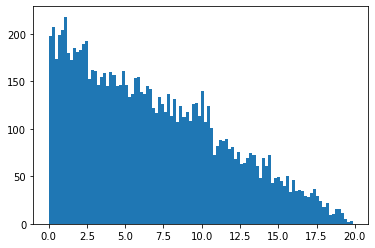

In [8]:
# Task 4 initialisation

back = 10000 # Length of background
signal = 150 # Length of Signal
xmin = 0
xmax = 20

intercept2 = 15 # y-intercept guess
slope2 = -1.5 # slope guess
gauss_frac = 0.15 #fraction of gaussian distribution guess

dist = SignalWithBackground(intercept,slope,XMIN,XMAX,mean,sigma) 
dist.summing(back,signal) # Create a pdf with 150 signal and 10000 background

data = np.asarray(dist.mass) # Convert to array to remove errors
a = plt.hist(data,bins = NBINS) # Initialise un-normalised histogram to get values
bin_widths = []
bin_centre = []
for i in range(len(a[1])-1):
    bin_widths.append(a[1][i+1]-a[1][i]) # find the bin widths (spoiler alert: they're all the same)
    bin_centre.append((a[1][i]+a[1][i+1])/2) # find the centre of each bin
    
bin_centre = np.array(bin_centre) # convert to array as function doesn't like lists

# Use optimize.minimize to find the minimum chi-square values (used Powell method as it gave me the best values) 
h_0 = opt.minimize(chi,x0=[slope2,intercept2],args=[a[0],xmin,xmax,bin_widths[1],bin_centre],method='powell')
h_1 = opt.minimize(chilg,x0=[slope2,intercept2,gauss_frac],args=[a[0],xmin,xmax,bin_widths[1],bin_centre],method='powell')

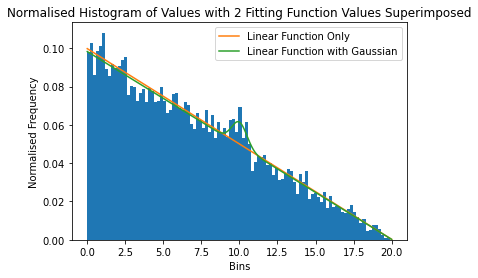

In [9]:
# Plotting the Histogram with the "lines of best fit"
xvalues = np.linspace(0,20,1000)
yvalues_lin = linear(h_0.x[0],h_0.x[1],xmin,xmax,xvalues) #calculate the values corresponding to the null hypothesis
yvalues_gauss = linearandgauss(h_1.x[0],h_1.x[1],h_1.x[2],xmin,xmax,xvalues) #calculate values corresponding signal hypothesis
plt.hist(data,bins = NBINS,density=True)
plt.plot(xvalues,yvalues_lin,label="Linear Function Only")
plt.plot(xvalues,yvalues_gauss,label="Linear Function with Gaussian")
plt.title("Normalised Histogram of Values with 2 Fitting Function Values Superimposed")
plt.xlabel("Bins")
plt.ylabel("Normalised Frequency")
plt.legend()
plt.show()

In [10]:
#Finding the chi-square difference:

D = h_0.fun-h_1.fun #difference between chi-square values
dof = 1 # 1 degree of freedom as only one parameter change between the two fits

print("Difference between chi-squared values = "+str(D)+"\n")

p_value_diff = 1-chi2.cdf(D,dof) # calculate p-value using chi square cdf
n_sigmas_diff = erfinv(1-p_value_diff)*np.sqrt(2)
print("P Value = "+str(p_value_diff)+"\n")
print("Z Value = "+str(n_sigmas_diff)+" sigma")

Difference between chi-squared values = 23.305247210815082

P Value = 1.3822240180205725e-06

Z Value = 4.827550850162254 sigma


This is a very high Z score meaning that this result is statistically significant over the background in normal physics. In other words, it was able to detect the signal we put in amongst the noise. Although for particle physics, it is not quite high enough to be claimed as a "discovery" (which requires 5 sigma). 